In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
from numpy.random import default_rng
from scipy import optimize
from scipy.integrate import quad 
import time
rng = default_rng()

In [2]:
#Killian Coustoulin
#21304858

# Illustration de la m√©thode de simulation d‚Äôun processus de Poisson homog√®ne ou inhomog√®ne par la m√©thode de thinning :


Les processus de Poisson sont utilis√©s pour mod√©liser l'apparition d'√©v√®nements al√©atoire au cours du temps. Quelques exemples d'utilisations des processus de Poisson : 

    -Arriv√©e de clients √† un centre-commercial
    -Nombre d'appel re√ßu √† un centre d'appel durant une p√©riode donn√©e
    -Apparition de tremblement de terre dans une r√©gion sp√©cifique
    -D√©sint√©gration radioactive

La liste n'est √©videmment pas exhaustive, on retrouve des processsus de Poisson dans de nombreux autres domaines, comme la t√©l√©communication, la biologie....

Toutes les cellules peuvent √™tre relanc√©s (dans l'ordre bien s√ªr) et s'ex√©cutent relativement rapidement, sauf les 
trois derni√®res, qui servent √† comparer les performances des divers algorithmes et sont assez lentes.

## Partie 1 : Simulation des processus de poisson homog√®ne et non homog√®ne 
### Processus de Poisson homog√®ne : 


Un processus de Poisson de param√®tre (ou intensit√©) $\lambda > 0$, est un processus de comptage associ√© √† un processus ponctuel $(T_n)_{n \ge 1}$ o√π les variables al√©atoires $T_n$ (appel√©es instants de sauts) sont d√©finies par
\begin{equation*}
    \forall n \ge 1, \quad T_n - T_{n-1} = S_n, \qquad \text{en posant $T_0 = 0$}
\end{equation*}
avec $(S_n)_{n \ge 1}$ suite _i.i.d._ de loi exponentielle de param√®tre $\lambda > 0$.

Pour tout $t \ge 0$, on d√©finit 
\begin{equation*}
    N_t = \sum_{n \ge 0} \mathbf{1}_{T_n \le t},
\end{equation*}



#### Simulation d'un processus homog√®ne par la m√©thode de la fonction inverse

In [3]:
def One_Poisson_Homogene_Inverse(lambd, T):
    sol = [0]
    compteur = 0 
    while sol[-1]<T:
        u = rng.uniform()
        w = -np.log(u)/lambd
        sol.append(sol[-1]+w)
        compteur+=1
    
    sol[-1]=T
    return np.array(sol)

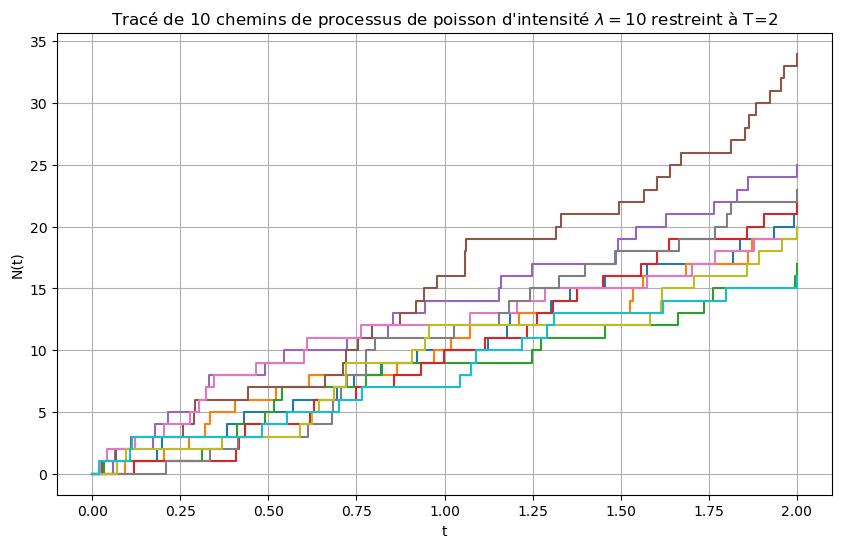

In [4]:
n = 10
lambd = 10
T = 2
sol = [ One_Poisson_Homogene_Inverse(lambd, T) for _ in range(n) ]


fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

for j in range(n):
    support = np.arange(len(sol[j]))
    ax.step(sol[j], support, where='post')
    
ax.grid()
ax.set_title(f"Trac√© de {n} chemins de processus de poisson d'intensit√© $\lambda=${lambd} restreint √† T={T}")
ax.set_xlabel('t')
ax.set_ylabel('N(t)')
plt.show()


#### Simulation d'un processus homog√®ne par la m√©thode d'arrangement

Si $(N_t)_{t \ge 0}$ est un processus de Poisson d'intensit√© $\lambda > 0$, alors conditionnellement √† l'√©v√©nement $N_T = n$ les instants de sauts $(T_k)_{k=1,\dots,n}$ (tels que $0 < T_1 < \dots < T_n \le T$) ont m√™me loi que le r√©ordonnement croissant d'un vecteur $(U_1, \dots, U_n) \sim \mathcal{U}([0,T]^n)$.

In [5]:
def One_Poisson_Homogene_Sort(lambd, T):
    size = rng.poisson(lam=lambd*T)
    times = np.empty(size+2)
    times[0] = 0
    times[1:-1] = np.sort(rng.uniform(size=size, low=0, high=T))
    times[-1] = T
    return times

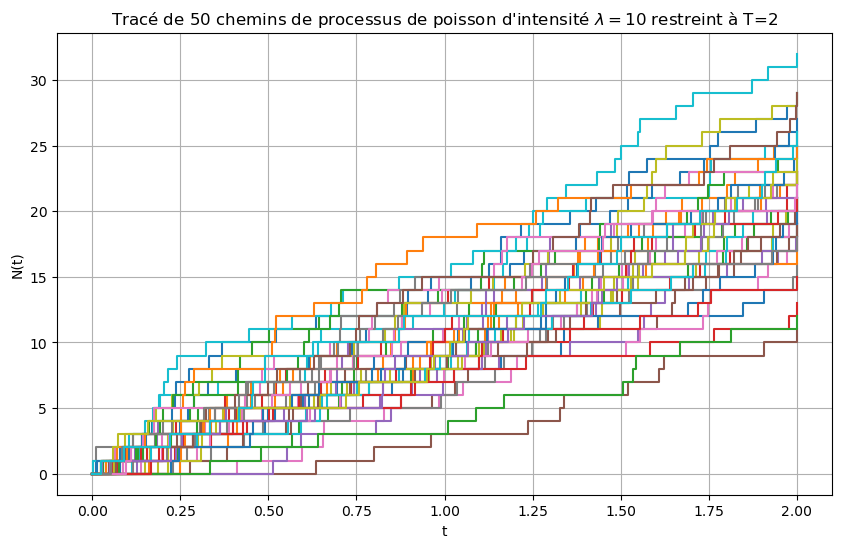

In [6]:
n = 50
lambd = 10
T = 2
sol = [ One_Poisson_Homogene_Sort(lambd, T) for _ in range(n) ]

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

for j in range(n):
    support = np.arange(len(sol[j]))
    ax.step(sol[j], support, where='post')
    
ax.grid()
ax.set_title(f"Trac√© de {n} chemins de processus de poisson d'intensit√© $\lambda=${lambd} restreint √† T={T}")
ax.set_xlabel('t')
ax.set_ylabel('N(t)')
plt.show()

#### Convergence du processus d'intensit√© $\lambda$ restreint √† T vers une loi de poisson $\lambda T$

Pour un temps t donn√© (strictement positif), le nombre $(N_t)$ d'occurrences dans un intervalle de longueur t suit une loi de Poisson d'intensit√© $\normalsize\lambda t$, c'est-√†-dire que $\quad \mathbf{P} (N_t=k)=  e^{-\lambda t}\large\frac{(\lambda t)^{2}}{k!}$    



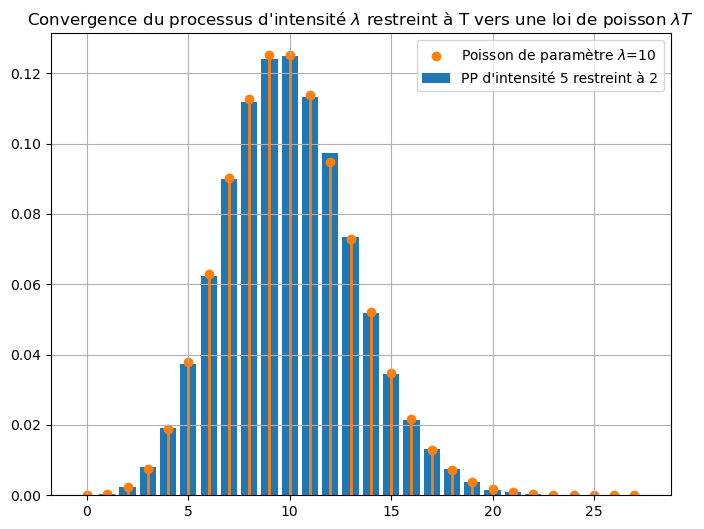

In [7]:
size = 100000
T = 2
lambd=5
poisson = stats.poisson(lambd*T)
sol  = [One_Poisson_Homogene_Inverse(lambd,T)[1:-1].size for _ in range(size)]
#Il faut exclure le premier et dernier point du calcul de taille, car le processus ne commence 
#v√©ritablement qu'apr√®s avoir tir√© une loi exponentielle inverse une fois, et la derni√®re
#valeur de sol est sup√©rieur √† T (on l'a transform√© en T pour rendre le graphique plus beau,
#donc elle ne fait pas partie du processus. 


fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
support = np.arange(np.max(sol)+1)
empirical_pro = np.bincount(sol,minlength=np.max(sol))/size
ax.bar(support,empirical_pro,label=f"PP d'intensit√© {lambd} restreint √† {T}")
ax.scatter(support, poisson.pmf(support), label=f'Poisson de param√®tre $\lambda$={lambd*T}')
ax.vlines(support, 0, poisson.pmf(support), color='C1', lw=2, alpha=1)
ax.set_title("Convergence du processus d'intensit√© $\lambda$ restreint √† T vers une loi de poisson $\lambda T$")
ax.grid()
ax.legend()
plt.show()

### Processus de poisson non homog√®ne


On consid√®re un processus de Poisson de param√®tre (ou l'intensit√©) $\lambda(t)$ est une fonction de R+ vers R+ int√©grable.
Le processus de comptage {$N_t,t ‚àà {\rm I\!R+}$} est appel√© un processus de poisson non homog√®ne d'intensit√© $\lambda(t)$ si $N_t$ satisfait : 
- Les incr√©ments de $N_t$ sont ind√©pendants entre eux
- $N_0=0$
- pour tout $t ‚àà {\rm I\!R+}$, on a : $\mathbf{P}(N_{t+h}-N_t = 1) = \lambda(t)h + o(h)$  et  $\mathbf{P}(N_{t+h}-N_t > 2) = o(h)$ 



In [8]:
#Quelques fonctions que nous utiliserons comme param√®tre des processus non homog√®nes et une red√©finition de l'int√©grale pour 
#simplifier la lecture

def integrale(f,a,b):
    return quad(f,a,b)[0]


def f1(x):
    return x**2
def f2(x):
    return 1 + np.sin(x)
def f3(x):
    return 10*stats.norm(loc=2,scale=1).pdf(x)
def f4(x):
    return (5+np.exp(-x))/(2+np.sin(x))

nom_fonction = ["$f_{1}(x)=x^{2}$", "$f_{2}(x)=1+sin(x)$", "$f_{3}$ ~ $10*\mathcal{N}(2, 1)$",'$f_{4}=\\frac{5+e^{-x}}{2+sin(x)}$']

#### Simulation d'un processus non homog√®ne par la m√©thode de la fonction inverse

Soit $N_t$ un processus de Poisson non homog√®ne de fonction d‚Äôintensit√© $\lambda$ et de fonction moyenne Œõ tel que Œõ(ùë°) =$\int_0^t \lambda(a)\,da$, alors $N_t$ suit une loi de Poisson de param√®tre Œõ(t). 

Pour simuler ce processus de poisson, il suffit donc de simuler un processsus de poisson homog√®ne d'intensit√© 1, puis d'appliquer la transformation $T_k = Œõ^{-1}(t_k)$ avec $t_k$ les temps d'arriv√©es du processus homog√®ne. (M√©thode Cinlar)

Cette m√©thode est couteuse, et il existe un autre algorithme fonctionnant sur le m√™me proc√©d√© que j'ai utilis√© ici :
Cette m√©thode utilise la distribution conditionnelle inter-√©l√©ment.

On consid√©re les $X_i = T_{i+1}-T_i$ conditionn√© par les √©v√®nements $T_1=t_1,T_2=t_2...T_i=t_i$, Alors on a : 

$F_{t_i}(x) = \mathbf{P}(X_i<x | T_1=t_1,T_2=t_2...T_i=t_i) $<br>$= \mathbf{P}(N_{t_i+x}-N_{t_i} \geq 1 | T_1=t_1,T_2=t_2...T_i=t_i)
$<br>$= \mathbf{P}(N_{t_i+x}-N_{t_i} \geq 1)$<br>$ = 1 - \mathbf{P}(N_{t_i+x}-N_{t_i} = 0) $<br>$= 1 - exp(-Œõ(t_i+x) + Œõ(t_i))$

Pour trouver le temps $T_k$, il suffit donc de g√©n√©rer U uniforme et de r√©soudre $x = inf(x : F_t(x)\geq u)$, ici j'utilise une simple m√©thode de dichotomie.

In [9]:
#Calcul de x = inf(x : Ft(x) >= u)
def dichotomie(f,t,u,T, n=20):
    
    def Ft(x):
        return 1 - np.exp(-integrale(f,t,t+x))    
    
    a = 0
    b = T   
    for j in range(n):
        if Ft((a+b)/2)<u:
            a = (a+b)/2
        else : 
            b = (a+b)/2
    return (a+b)/2
    
def one_Poisson_nonHomog√®ne_inversion(f,T):
       
    sol = [0]  
    while sol[-1]<T:        
        u = rng.uniform()
        t = dichotomie(f,sol[-1],u,T)
        sol.append(sol[-1]+t)
              
    sol[-1]=T
    return np.array(sol)

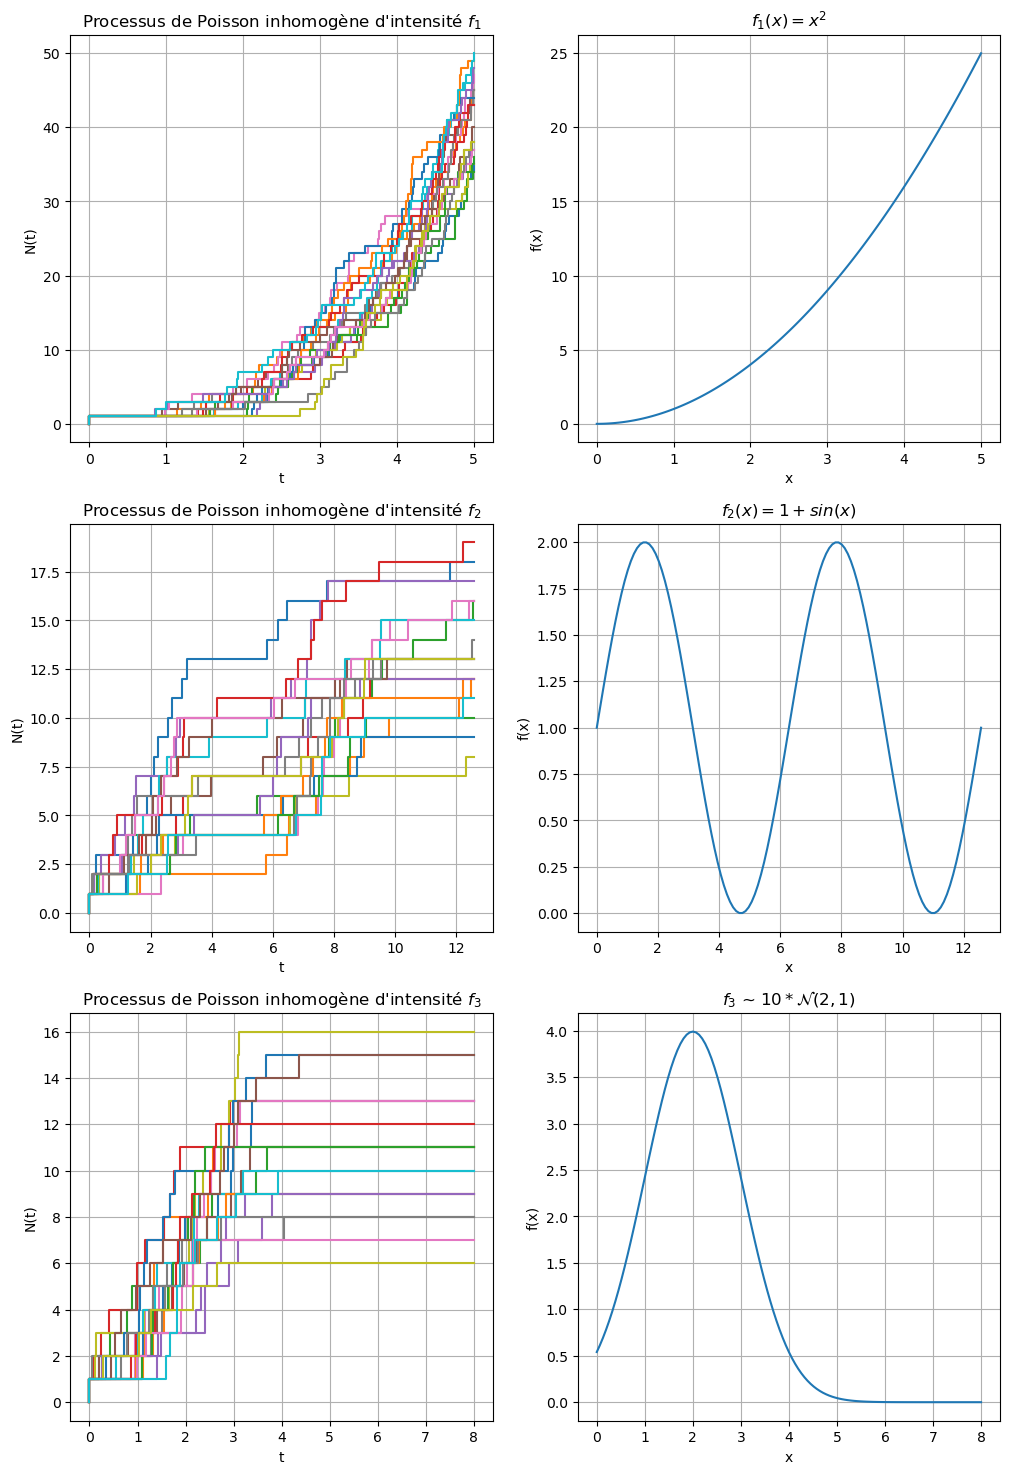

In [10]:
Ts = [5,4*np.pi,8]
n = 20
fs = [f1,f2,f3]
fig = plt.figure(figsize=(12,18))


for i in range(3):
    T = Ts[i]
    f = fs[i]
    sol = [one_Poisson_nonHomog√®ne_inversion(f,T) for _ in range(n)]
    ax1 = fig.add_subplot(3,2,(2*i)+1)
    for j in range(n):
        support = np.arange(sol[j].size)
        ax1.step(sol[j],support)
    ax1.grid()
    ax1.set_xlabel('t')
    ax1.set_ylabel('N(t)')
    ax1.set_title(f"Processus de Poisson inhomog√®ne d'intensit√© $f_{i+1}$")
    
    xx = np.linspace(0,T,125)
    ax2 = fig.add_subplot(3,2,(2*i)+2)
    ax2.plot(xx,f(xx))
    ax2.grid()
    ax2.set_xlabel('x')
    ax2.set_ylabel('f(x)')
    ax2.set_title(nom_fonction[i])
plt.show()

On remarque que le temps d'ex√©cution est relativement long, mais on y reviendra plus tard. 

#### Convergence du processsus homog√®ne d'intensit√© $\lambda(t)$ restreint √† T vers la loi de poisson d'intensit√© integrale $\int_0^T \lambda(a)\,da$
Le nombre d'arriv√©es dans n'importe quel interval d'un processus de poisson d'intensit√© $\lambda(t)$ suit une loi de Poisson.
Plus pr√©cis√©ment, 
$$\normalsize  N_{t+s}-N_t \thicksim Poisson(\int_t^{t+s} \lambda(a)\,da)$$

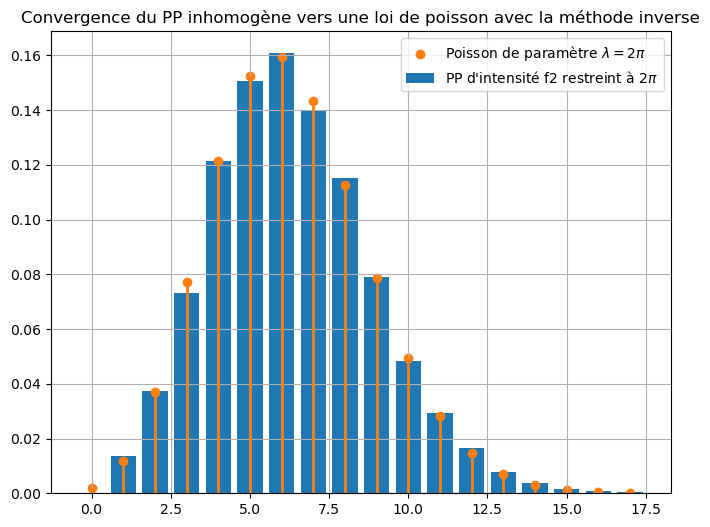

In [11]:
size = 10000
T = 2*np.pi
f = f2
lambd=integrale(f,0,T)
poisson = stats.poisson(lambd)
sol  = [one_Poisson_nonHomog√®ne_inversion(f,T)[1:-1].size for _ in range(size)]

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
support = np.arange(np.max(sol)+1)
empirical_pro = np.bincount(sol,minlength=np.max(sol))/size
ax.bar(support,empirical_pro,label=f"PP d'intensit√© f2 restreint √† 2$\pi$")
ax.scatter(support, poisson.pmf(support), label=f'Poisson de param√®tre $\lambda=2\pi$')
ax.vlines(support, 0, poisson.pmf(support), color='C1', lw=2, alpha=1)
ax.grid()
ax.legend()
ax.set_title('Convergence du PP inhomog√®ne vers une loi de poisson avec la m√©thode inverse')
plt.show()

## Partie 2 : Thinning algorithm



### Splitting d'un processus de poisson homog√®ne par une loi de bernouilli 

On commence par une version basique mais tr√®s proche de la m√©thode de thinning, qui consiste simplement √† un diviser processus de poisson selon une loi de bernouilli.

Soit $N_t$ un processus de poisson d'intensit√© $\lambda$. Si, pour chaque arriv√©e, on tire une variable de bernouilli B
de param√®tre p, tel que si B=1 l'arriv√©e est envoy√© vers le processus $N^{(1)}_t$ et sinon vers $N^{(2)}_t$, alors :

 -$N^{(1)}_t$ est un processus de poisson homog√®ne d'intensit√© $\lambda p$ <br>
 -$N^{(2)}_t$ est un processus de poisson homog√®ne d'intensit√© $(1-\lambda) p$

In [12]:
def One_Poisson_Splitting(lambd, T, p):
      
    process = One_Poisson_Homogene_Inverse(lambd, T)

    accep = [0]
    rejet = [0]
    U = rng.uniform(size=process.size)
    
    for i in range(process.size) :
       
        if U[i]<=p:
            accep.append(process[i])
        else : 
            rejet.append(process[i])
    return np.array(accep), np.array(rejet)
            
def Poisson_Splitting(lambd, T, p, sample_size):
    sol1 = []
    sol2 = []
    for j in range(sample_size):
        temp1,temp2 = One_Poisson_Splitting(lambd, T, p)
        sol1.append(temp1[1:-1].size)
        sol2.append(temp2[1:-1].size)
    return np.array(sol1), np.array(sol2)
        

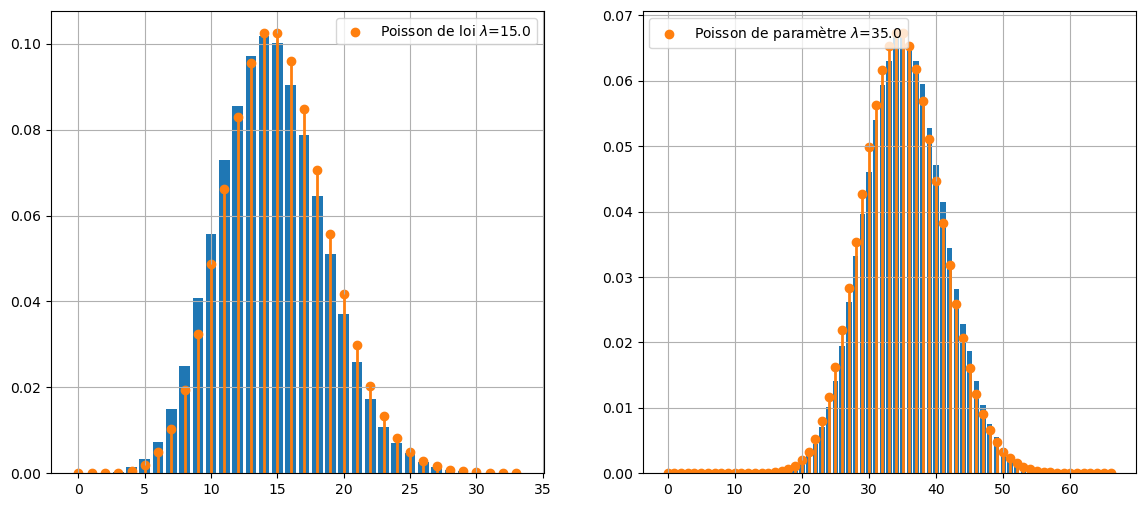

In [13]:
size = 100000
T = 10
lambd=5
p=0.3
poisson1 = stats.poisson(T*lambd*p)
poisson2 = stats.poisson(T*lambd*(1-p))
sol1,sol2  = Poisson_Splitting(lambd, T, p, size)


fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(1,2,1)
support = np.arange(np.max(sol1)+1)
empirical_pro = np.bincount(sol1,minlength=np.max(sol1))/sol1.size
ax1.bar(support,empirical_pro)
ax1.scatter(support, poisson1.pmf(support), label=f'Poisson de loi $\lambda$={round(T*p*lambd,2)}')
ax1.vlines(support, 0, poisson1.pmf(support), color='C1', lw=2, alpha=1)
ax1.grid()
ax1.legend()


ax2 = fig.add_subplot(1,2,2)
support = np.arange(np.max(sol2)+1)
empirical_pro = np.bincount(sol2,minlength=np.max(sol2))/sol2.size
ax2.bar(support,empirical_pro)
ax2.scatter(support, poisson2.pmf(support), label=f'Poisson de param√®tre $\lambda$={round((1-p)*lambd*T,2)}')
ax2.vlines(support, 0, poisson2.pmf(support), color='C1', lw=2, alpha=1)
ax2.grid()
ax2.legend()
plt.show()


### Simulation d'un processus non homog√®ne par la m√©thode de thinning
Th√©or√®me de Lewis et Shedler : Soit un processus de Poisson d'intensit√© $\lambda_u(t), t\geq 0$. Supposons que
les $T_{1}^{*},T_{1}^{*},....,T_{n}^{*}$ sont des variables al√©atoires repr√©sentant les temps d'arriv√©es pour ce processus de poisson, se situant entre 0 et T. Sois $\lambda(t)$ une fonction d'intensit√© telle que $0\leq \lambda(t) \leq \lambda_u(t)$
pour $t ‚àà [0,T]$. Si le i-√®me temps d'arriv√©e $T_{i}^{*}$ est rejet√© avec probabilit√© $1-\large\frac{\lambda(t)}{\lambda_u(t)}$ pour $i=1,2...n$, alors les points restant forment un processus de Poisson non homog√®ne d'intensit√© $\lambda(t)$ restreint √† $T$.

Pour la premi√®re impl√©mentation, j'utilise $\lambda_u(t)=sup_t \lambda(t)$.

In [14]:
#Recherche du sup de f sur l'intervalle [0,T]

def sup(f,t1,t2):
    intervalle = np.linspace(t1,t2,5)
    x0 = t1
    for x in intervalle:
        if(f(x)>f(x0)):
            x0 = x
    xmax = optimize.minimize(lambda x: -f(x), x0, bounds=[(t1,t2)]).x[0]
    return f(xmax)

J'utilise la fonction optimize.minimize de Scipy. Cependant, cette fonction ne renvoit pas toujours un maximum global
et se retrouve souvent bloqu√© dans un maximum local ( minimum normalement, mais j'optimise -f donc c'est bien un maximum de f ). Pour contrer cela, j'essaie, de mani√®re tr√®s rudimentaire, de chercher un point x0 optimale en √©valuent la fonction sur 5 points et d'initaliser optimize.minimize avec le point qui maximize f.

In [15]:
def Poisson_nonHomog√®ne_thinning(f,T):
    
    
    lambd = sup(f,0,T)
        
    #Generation d'un processus de poisson d'intensit√© lambd (le max de f sur l'intervalle [0,T])
    
    process = One_Poisson_Homogene_Sort(lambd,T)

   
    sol = [0]

    for p in process :
        
        #Seul les points validant le crit√®re sont gard√©s
        d = rng.uniform()
        if d<=f(p)/lambd:
            sol.append(p)

    sol[-1]=T
    return np.array(sol)


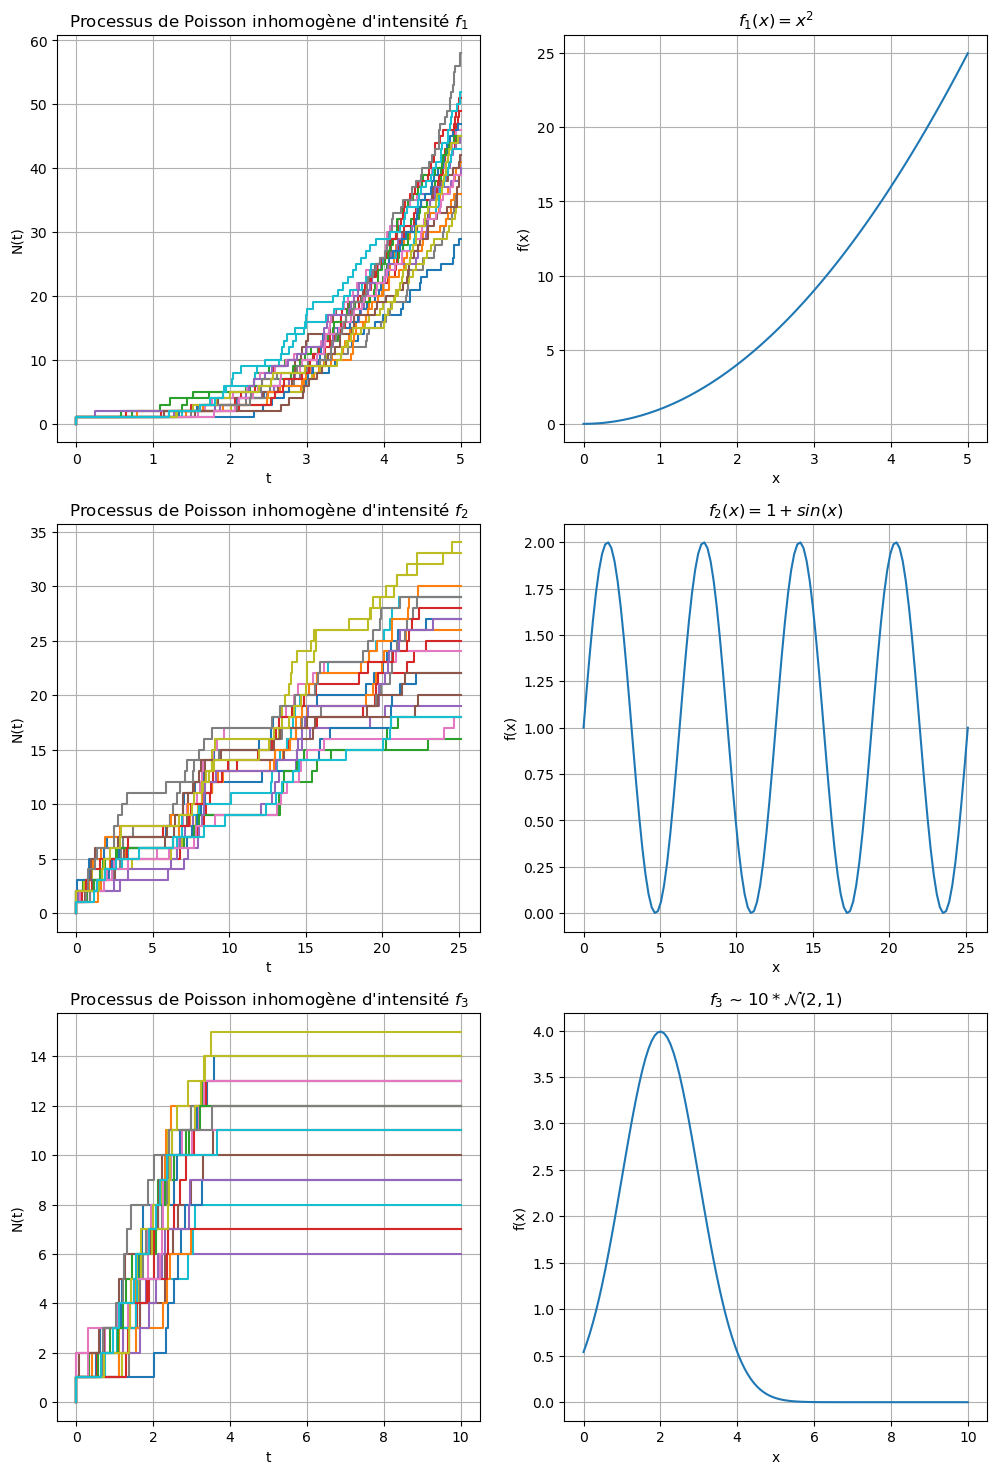

In [16]:
Ts = [5,8*np.pi,10]
n = 20
fs = [f1,f2,f3]
fig = plt.figure(figsize=(12,18))


for i in range(3):
    T = Ts[i]
    f = fs[i]
    sol  = [Poisson_nonHomog√®ne_thinning(f,T) for _ in range(n)]
    ax1 = fig.add_subplot(3,2,(2*i)+1)
    for j in range(n):
        support = np.arange(sol[j].size)
        ax1.step(sol[j],support)
    ax1.grid()
    ax1.set_xlabel('t')
    ax1.set_ylabel('N(t)')
    ax1.set_title(f"Processus de Poisson inhomog√®ne d'intensit√© $f_{i+1}$")
    
    xx = np.linspace(0,T,125)
    ax2 = fig.add_subplot(3,2,(2*i)+2)
    ax2.plot(xx,f(xx))
    ax2.grid()
    ax2.set_xlabel('x')
    ax2.set_ylabel('f(x)')
    ax2.set_title(nom_fonction[i])

plt.show()

        

On remarque imm√©diatement que cette m√©thode est beaucoup plus rapide ! 

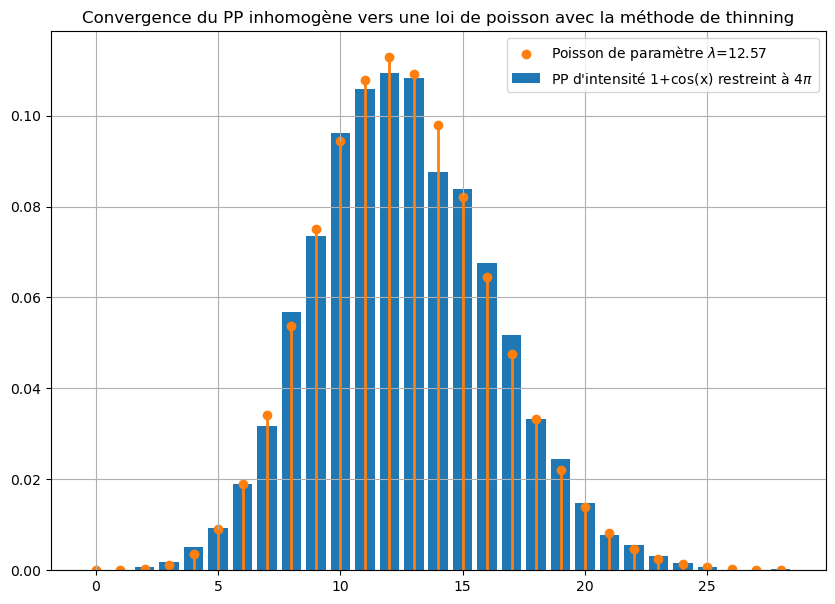

In [17]:
size = 10000
T = 4*np.pi
f = f2
lambd=integrale(f,0,T)
poisson = stats.poisson(lambd)
sol  = [Poisson_nonHomog√®ne_thinning(f,T)[1:-1].size for _ in range(size)]

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
support = np.arange(np.max(sol)+1)
empirical_pro = np.bincount(sol,minlength=np.max(sol))/size
ax.bar(support,empirical_pro,label=f"PP d'intensit√© 1+cos(x) restreint √† 4$\pi$")
ax.scatter(support, poisson.pmf(support), label=f'Poisson de param√®tre $\lambda$={round(lambd,2)}')
ax.vlines(support, 0, poisson.pmf(support), color='C1', lw=2, alpha=1)
ax.set_title('Convergence du PP inhomog√®ne vers une loi de poisson avec la m√©thode de thinning')
ax.grid()
ax.legend()
plt.show()

#### Illustration de la m√©thode de thinning

In [18]:
#Je r√©√©cris la m√©thode pour l'illustration plus bas

def Poisson_nonHomog√®ne_thinning_illustration(f,T):
    
    #Recherche du sup de f sur l'intervalle [0,T]
    
    lambd = sup(f,0,T)
    
    #Generation d'un processus de poisson d'intensit√© lambd 
    
    process = One_Poisson_Homogene_Inverse(lambd,T)
 
    accep = []
    rejet = []
    accepd = []
    rejetd = []
    for p in process :
       
        d = rng.uniform()
        if d<=f(p)/lambd:
            accep.append(p)
            accepd.append(d*lambd)
        else : 
            rejet.append(p)
            rejetd.append(d*lambd)
    sol[-1]=T
    return np.array(accep),np.array(rejet),np.array(accepd),np.array(rejetd)

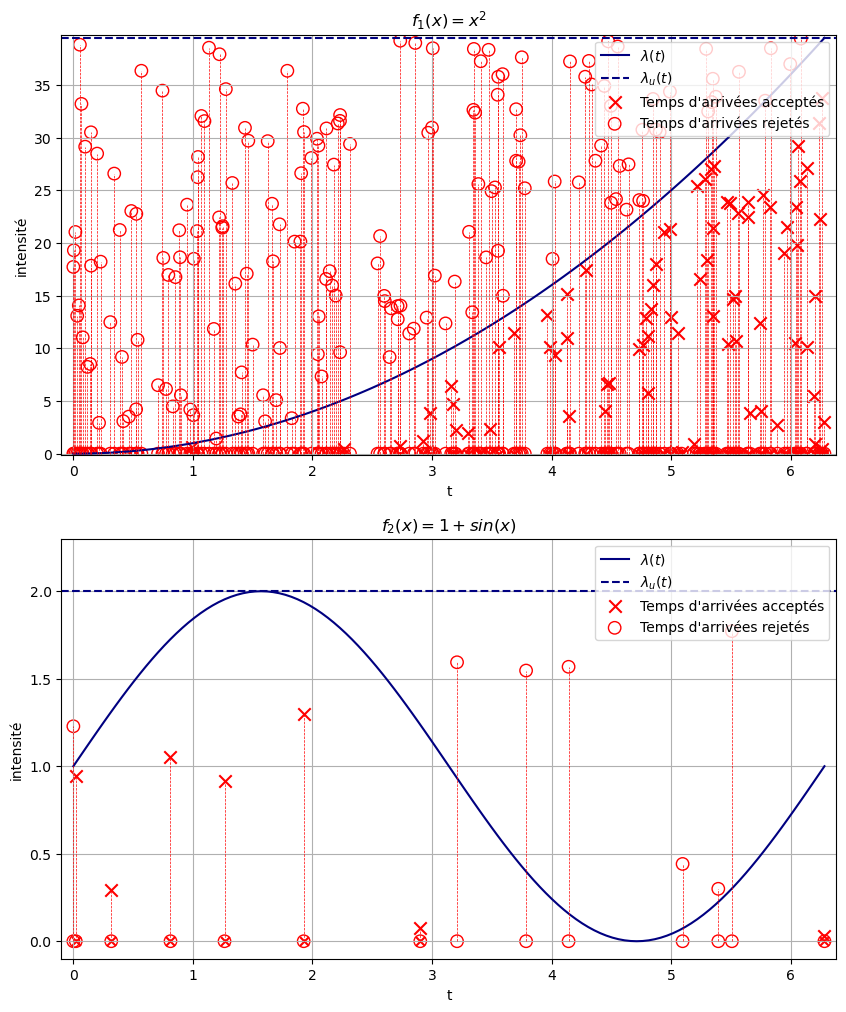

In [19]:
T = 2*np.pi
fs = [f1,f2]
fig = plt.figure(figsize=(10,6*len(fs)))


for i,f in enumerate(fs):
    lambd = sup(f,0,T)
    accep, rejet, accepd, rejetd = Poisson_nonHomog√®ne_thinning_illustration(f,T)

    ax = fig.add_subplot(len(fs),1,i+1)

    xx = np.linspace(0,T,125)
    ax.plot(xx,f(xx),label="$\lambda(t)$",color='navy')
    ax.axhline(y=lambd,linestyle='--',label="$\lambda_u(t)$",color='navy')

    ax.scatter(accep,np.zeros(accep.size), s=80, facecolors='none', edgecolors='r')
    ax.scatter(accep,accepd, marker='x', s=80,color='r',label="Temps d'arriv√©es accept√©s")
    ax.scatter(accep,np.zeros(accep.size), marker='x', s=40,color='r')

    ax.scatter(rejet,np.zeros(rejet.size), s=80, facecolors='none', edgecolors='r',label="Temps d'arriv√©es rejet√©s")
    ax.scatter(rejet,rejetd, s=80, facecolors='none', edgecolors='r')

    for j in range(accep.size):
        ax.plot(np.array([accep[j],accep[j]]),np.array([0,accepd[j]]),linestyle='--',color='r',linewidth=0.5)
    for j in range(rejet.size):
        ax.plot(np.array([rejet[j],rejet[j]]),np.array([0,rejetd[j]]),linestyle='--',color='r',linewidth=0.5)

    ax.set_xlim(-0.1,T+0.1)
    ax.set_ylim(-0.1,lambd+0.3)
    ax.grid()
    ax.set_xlabel('t')
    ax.set_ylabel('intensit√©')
    ax.set_title(f"{nom_fonction[i]}")
    ax.legend(loc="upper right")
plt.show()

#Regardez plut√¥t le deuxi√®me graphique en premier, qui est beaucoup plus clair !

Un probl√®me √©vident est mis en avant par ces illustrations, le nombre de points rejet√©s. <br>
En particulier, si la fonction d'intensit√© $\lambda(t)$ poss√®de un maximum sur [0,T] qui est tr√®s important 
compar√© √† sa valeur moyenne, il faudra simuler un processus d'intensit√© tr√®s forte $\lambda_{u}(t)$, qui conduira
√† une quantit√© tr√®s importante de points rejet√©s.

### Simulation d'un processus non homog√®ne par une m√©thode de thinning subdivis√©e

Pour optimiser l'algorithme, on va chercher √† r√©duire au maximul le nombre de points rejet√©s. Au lieu d'utiliser 
$\lambda_u(t)=sup_t \lambda(t)$, on divise la fonction en plusieurs morceaux et on calcule $\lambda_u(t)$ pour chaque morceau.
Ensuite, il suffit de g√©n√©rer un processus homog√®ne d'intensit√© $\lambda_u(t)$ pour chaque morceau et de proc√©der comme la m√©thode de thinning.


In [20]:
def Poisson_nonHomog√®ne_subdivision(f,T,nb_intervalles = 2):
          
    sol = [0]
    intervalles = np.linspace(0,T,nb_intervalles+1)
    for T_temp,T_temp_avant in zip(intervalles[1:],intervalles[:-1]):
           
        lambd_u = sup(f,T_temp_avant,T_temp)    
        process = One_Poisson_Homogene_Sort(lambd_u,T_temp)[1:-1] + sol[-1]
        
        i = 0 
        while sol[-1]<T_temp and i<process.size:
            d = rng.uniform()
            if d<=f(process[i])/lambd_u:
                sol.append(process[i])

            i+=1          
            
    sol[-1]=T

    return np.array(sol)



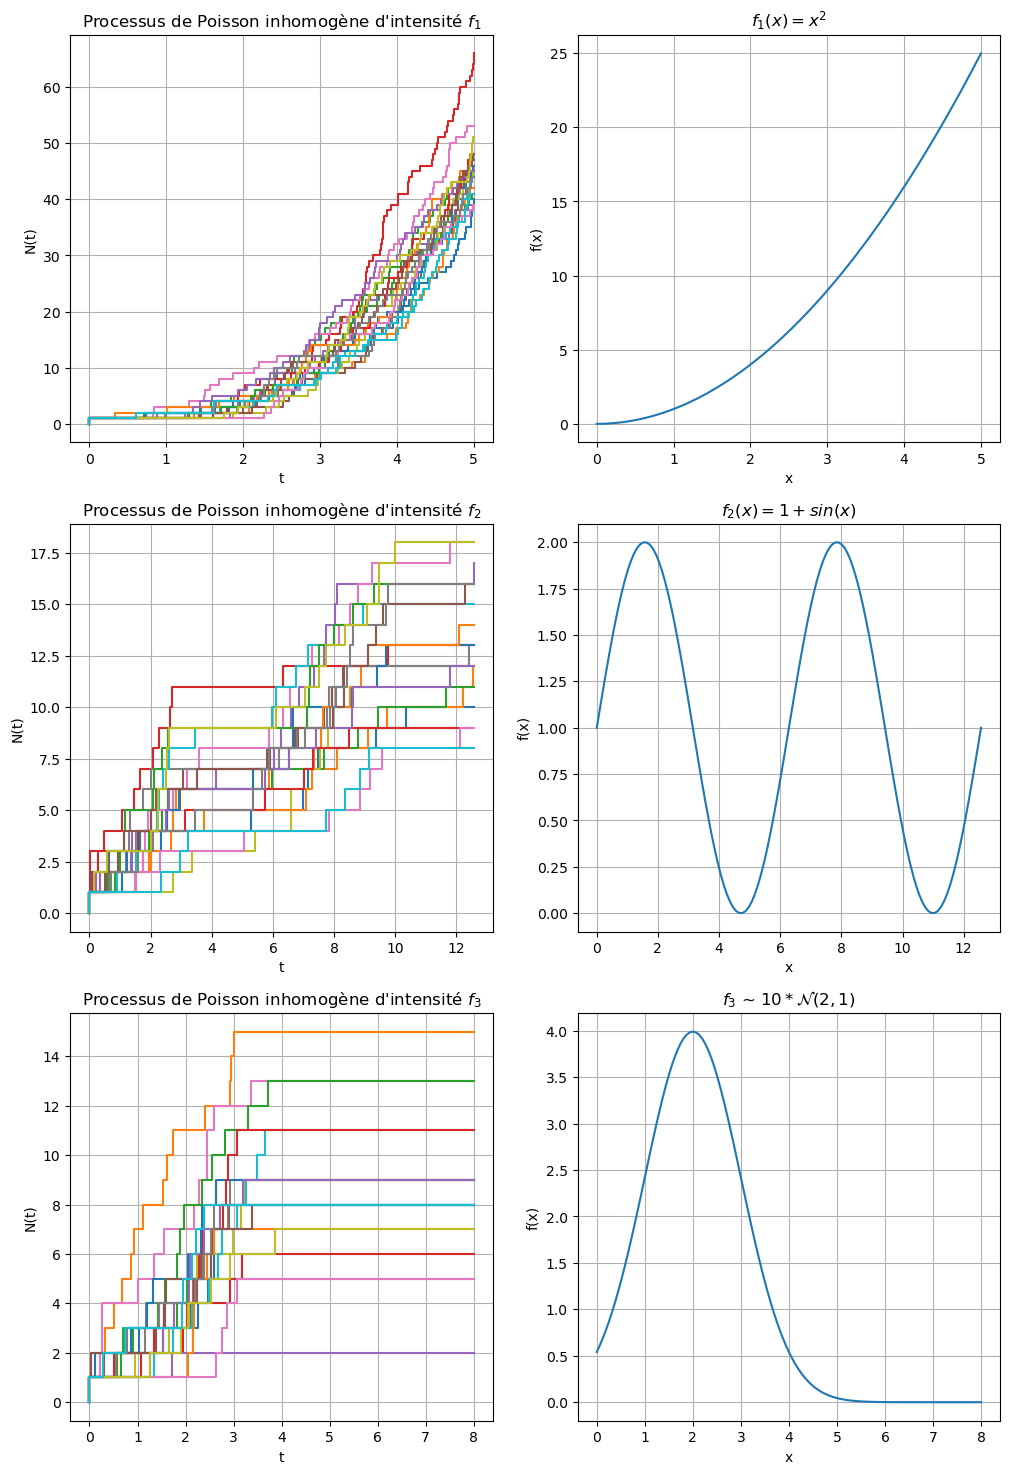

In [21]:
Ts = [5,4*np.pi,8]
n = 20
fs = [f1,f2,f3]
fig = plt.figure(figsize=(12,18))


for i in range(3):
    T = Ts[i]
    f = fs[i]
    sol  = [Poisson_nonHomog√®ne_subdivision(f,T) for _ in range(n)]
    ax1 = fig.add_subplot(3,2,(2*i)+1)
    for j in range(n):
        support = np.arange(sol[j].size)
        ax1.step(sol[j],support)
    ax1.grid()
    ax1.set_xlabel('t')
    ax1.set_ylabel('N(t)')
    ax1.set_title(f"Processus de Poisson inhomog√®ne d'intensit√© $f_{i+1}$")
    
    xx = np.linspace(0,T,125)
    ax2 = fig.add_subplot(3,2,(2*i)+2)
    ax2.plot(xx,f(xx))
    ax2.grid()
    ax2.set_xlabel('x')
    ax2.set_ylabel('f(x)')
    ax2.set_title(nom_fonction[i])

plt.show()



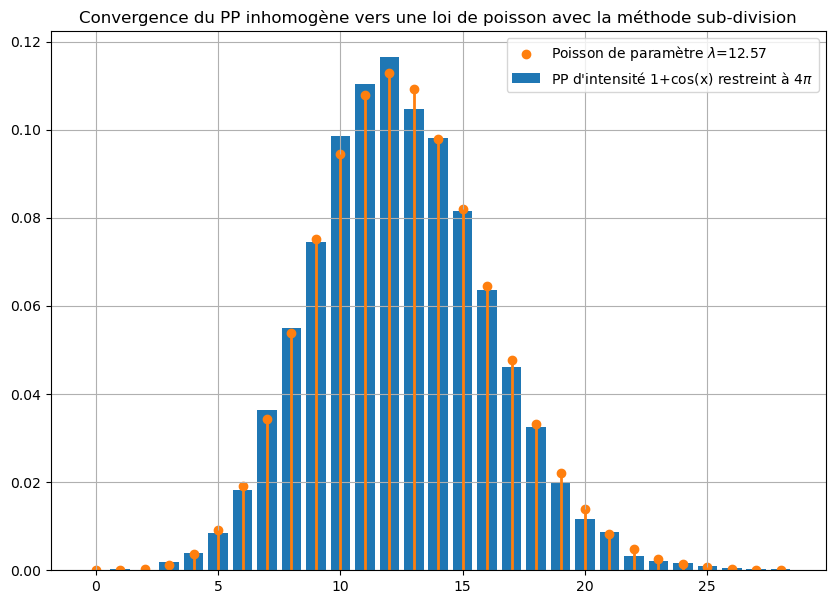

In [22]:
size = 10000
T = 4*np.pi
f = f2
lambd=integrale(f,0,T)
poisson = stats.poisson(lambd)
sol  = [Poisson_nonHomog√®ne_subdivision(f,T)[2:-1].size for _ in range(size)]

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1,1,1)
support = np.arange(np.max(sol)+1)
empirical_pro = np.bincount(sol,minlength=np.max(sol))/size
ax.bar(support,empirical_pro,label=f"PP d'intensit√© 1+cos(x) restreint √† 4$\pi$")
ax.scatter(support, poisson.pmf(support), label=f'Poisson de param√®tre $\lambda$={round(lambd,2)}')
ax.vlines(support, 0, poisson.pmf(support), color='C1', lw=2, alpha=1)
ax.set_title('Convergence du PP inhomog√®ne vers une loi de poisson avec la m√©thode sub-division')
ax.grid()
ax.legend()
plt.show()

## Partie 3 : Comparaison des performances

Nous avons donc √©crit 3 algorithmes pour simuler un processus de poisson non homog√®ne. Il faut maintenant comparer leurs performances en utilisant divers fonctions.

ATTENTION : La 1√®re et 3√®me cellules sont longues √† ex√©cuter selon la puissance de votre ordinateur 

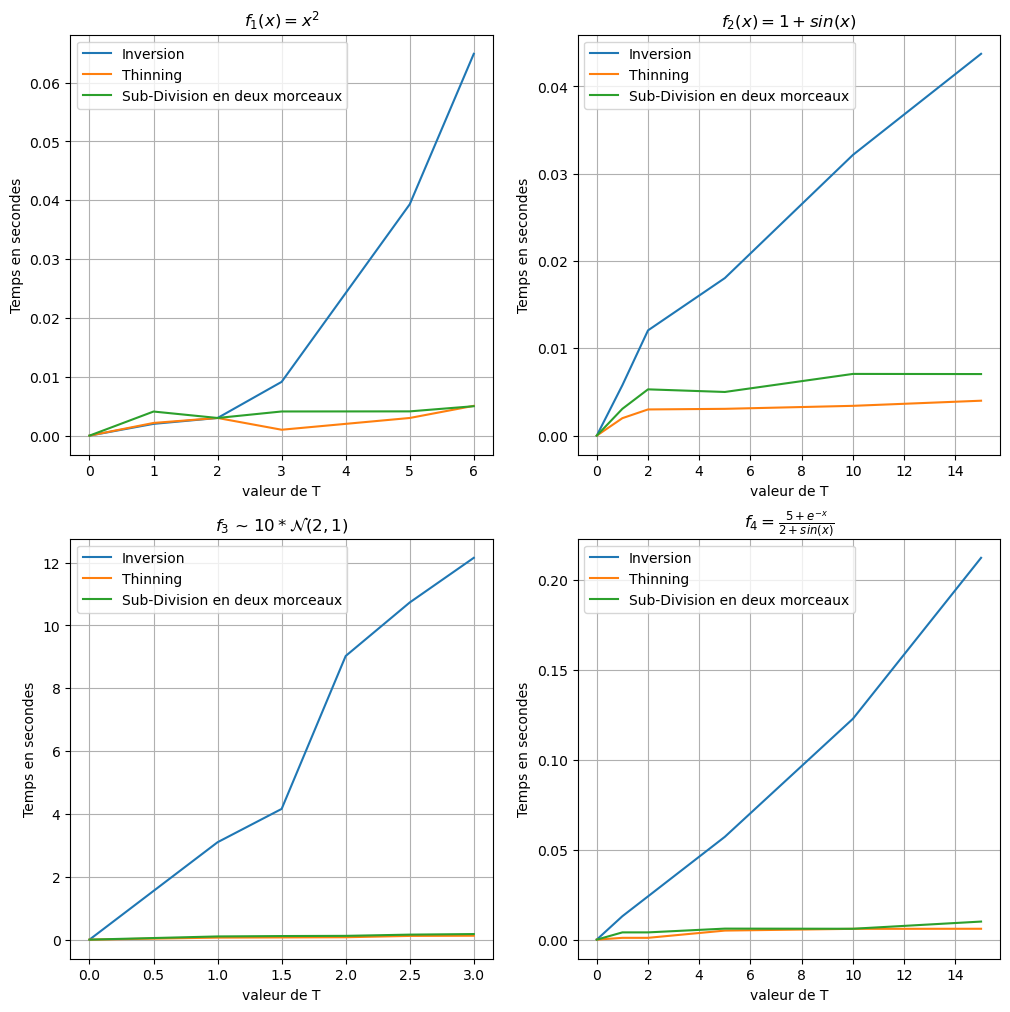

In [23]:
Ts = np.array([[0,1,2,3,5,6],[0,1,2,5,10,15],[0,1,1.5,2,2.5,3],[0,1,2,5,10,15]])
fs = [f1,f2,f3,f4]
fig = plt.figure(figsize=(12,12))

methodes = [one_Poisson_nonHomog√®ne_inversion, 
           Poisson_nonHomog√®ne_thinning,
           Poisson_nonHomog√®ne_subdivision]

nom = ['Inversion','Thinning','Sub-Division en deux morceaux']
titre = ['$f(x)=x^{2}$','$f(x)=1+sin(x)$','f3','f4']
for i,f in enumerate(fs) : 
    temps = [[0],[0],[0]]

    for T in Ts[i,1:]:
        for t,m in zip(temps,methodes):
            start = time.time()
            sol = [m(f,T) for _ in range(10)]
            end = time.time()
            t.append(end-start)
        
    ax = fig.add_subplot(2,2,i+1)
    for j,t in enumerate(temps):
        ax.plot(Ts[i],t,label=nom[j])
    ax.legend()
    ax.grid()
    ax.set_title(nom_fonction[i])
    ax.set_xlabel('valeur de T')
    ax.set_ylabel('Temps en secondes')
plt.show()
    

Clairement, la m√©thode de thinning et sa variante sont bien plus rapide que la m√©thode d'inversion.
On va comparer plus en d√©tail ces deux derni√®res m√©thodes : 

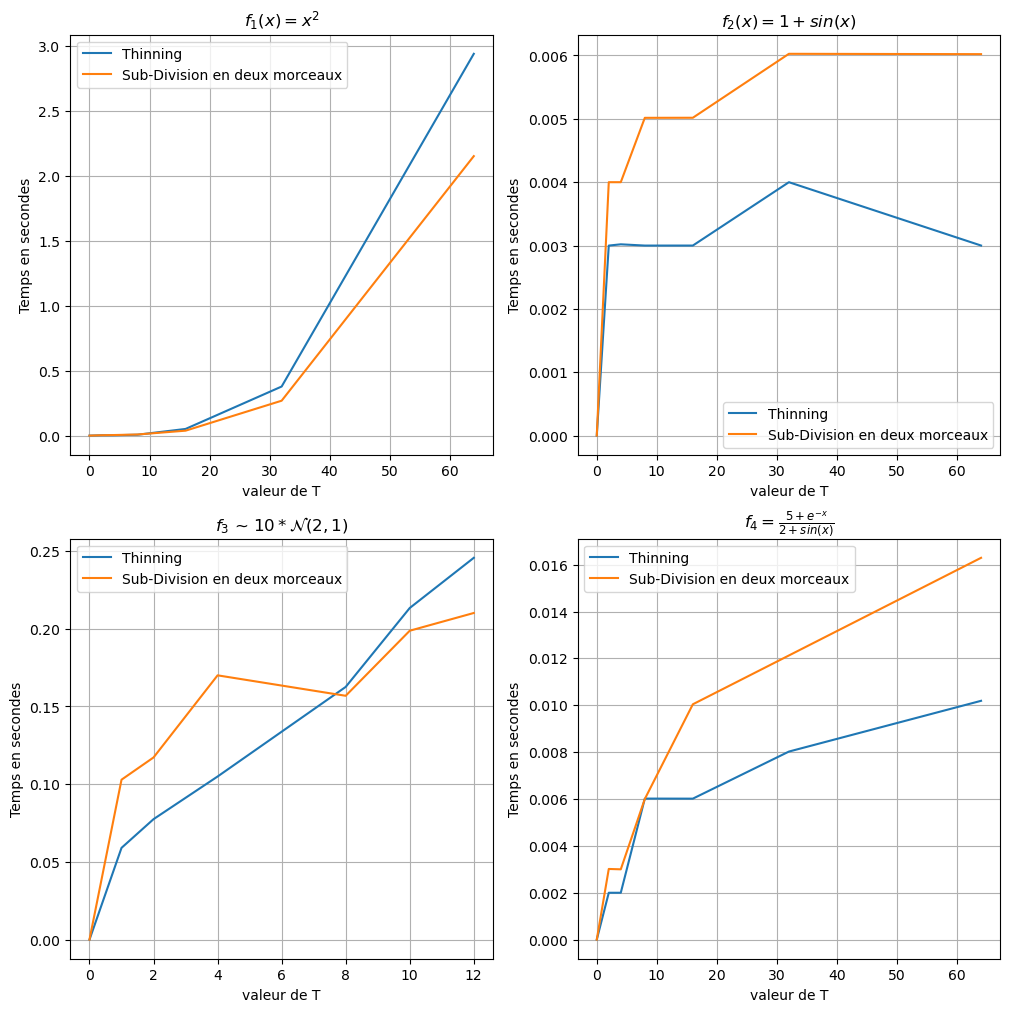

In [24]:
Ts = np.array([[0,2,4,8,16,32,64],[0,2,4,8,16,32,64],[0,1,2,4,8,10,12],[0,2,4,8,16,32,64]])
fs = [f1,f2,f3,f4]
fig = plt.figure(figsize=(12,12))

methodes = [Poisson_nonHomog√®ne_thinning, Poisson_nonHomog√®ne_subdivision]

nom = ['Thinning','Sub-Division en deux morceaux']
for i,f in enumerate(fs) : 
    temps = [[0],[0]]

    for T in Ts[i,1:]:
        for t,m in zip(temps,methodes):
            start = time.time()
            sol = [m(f,T) for _ in range(10)]
            end = time.time()
            t.append(end-start)
        
    ax = fig.add_subplot(2,2,i+1)
    for j,t in enumerate(temps):
        ax.plot(Ts[i],t,label=nom[j])
    ax.legend()
    ax.grid()
    ax.set_title(nom_fonction[i])
    ax.set_xlabel('valeur de T')
    ax.set_ylabel('Temps en secondes')
plt.show()

On remarque que les performances de ces deux algorithmes d√©pend de $\lambda(t)=f(t)$. L'explication est intuitivement claire : Plus la fonction pr√©sente des √©carts important entre son maximum et sa valeur moyenne, plus l'algorithme de sub-division prend de l'inter√™t. En effet, dans ce cas l√†, ne calculer que une seule fois le maximum de f entraine un nombre important de 
rejets. 

Th√©roriquement, la m√©thode de sub-division devrait √™tre meilleur ou √©gale √† la m√©thode de thinning, selon la valeur de $\lambda_{u}$ compar√© √† la moyenne de $\lambda(t)$. En pratique, la mauvaise optimisation de la recherche du sup $\lambda_u$ ralentit la fonction sub-division si couper la fonction en deux ou plus est inutile.

Cependant, il existe probablement une valeur optimale du nombre de subdivision, ce que l'on va v√©rifier dans ce dernier graphique : 

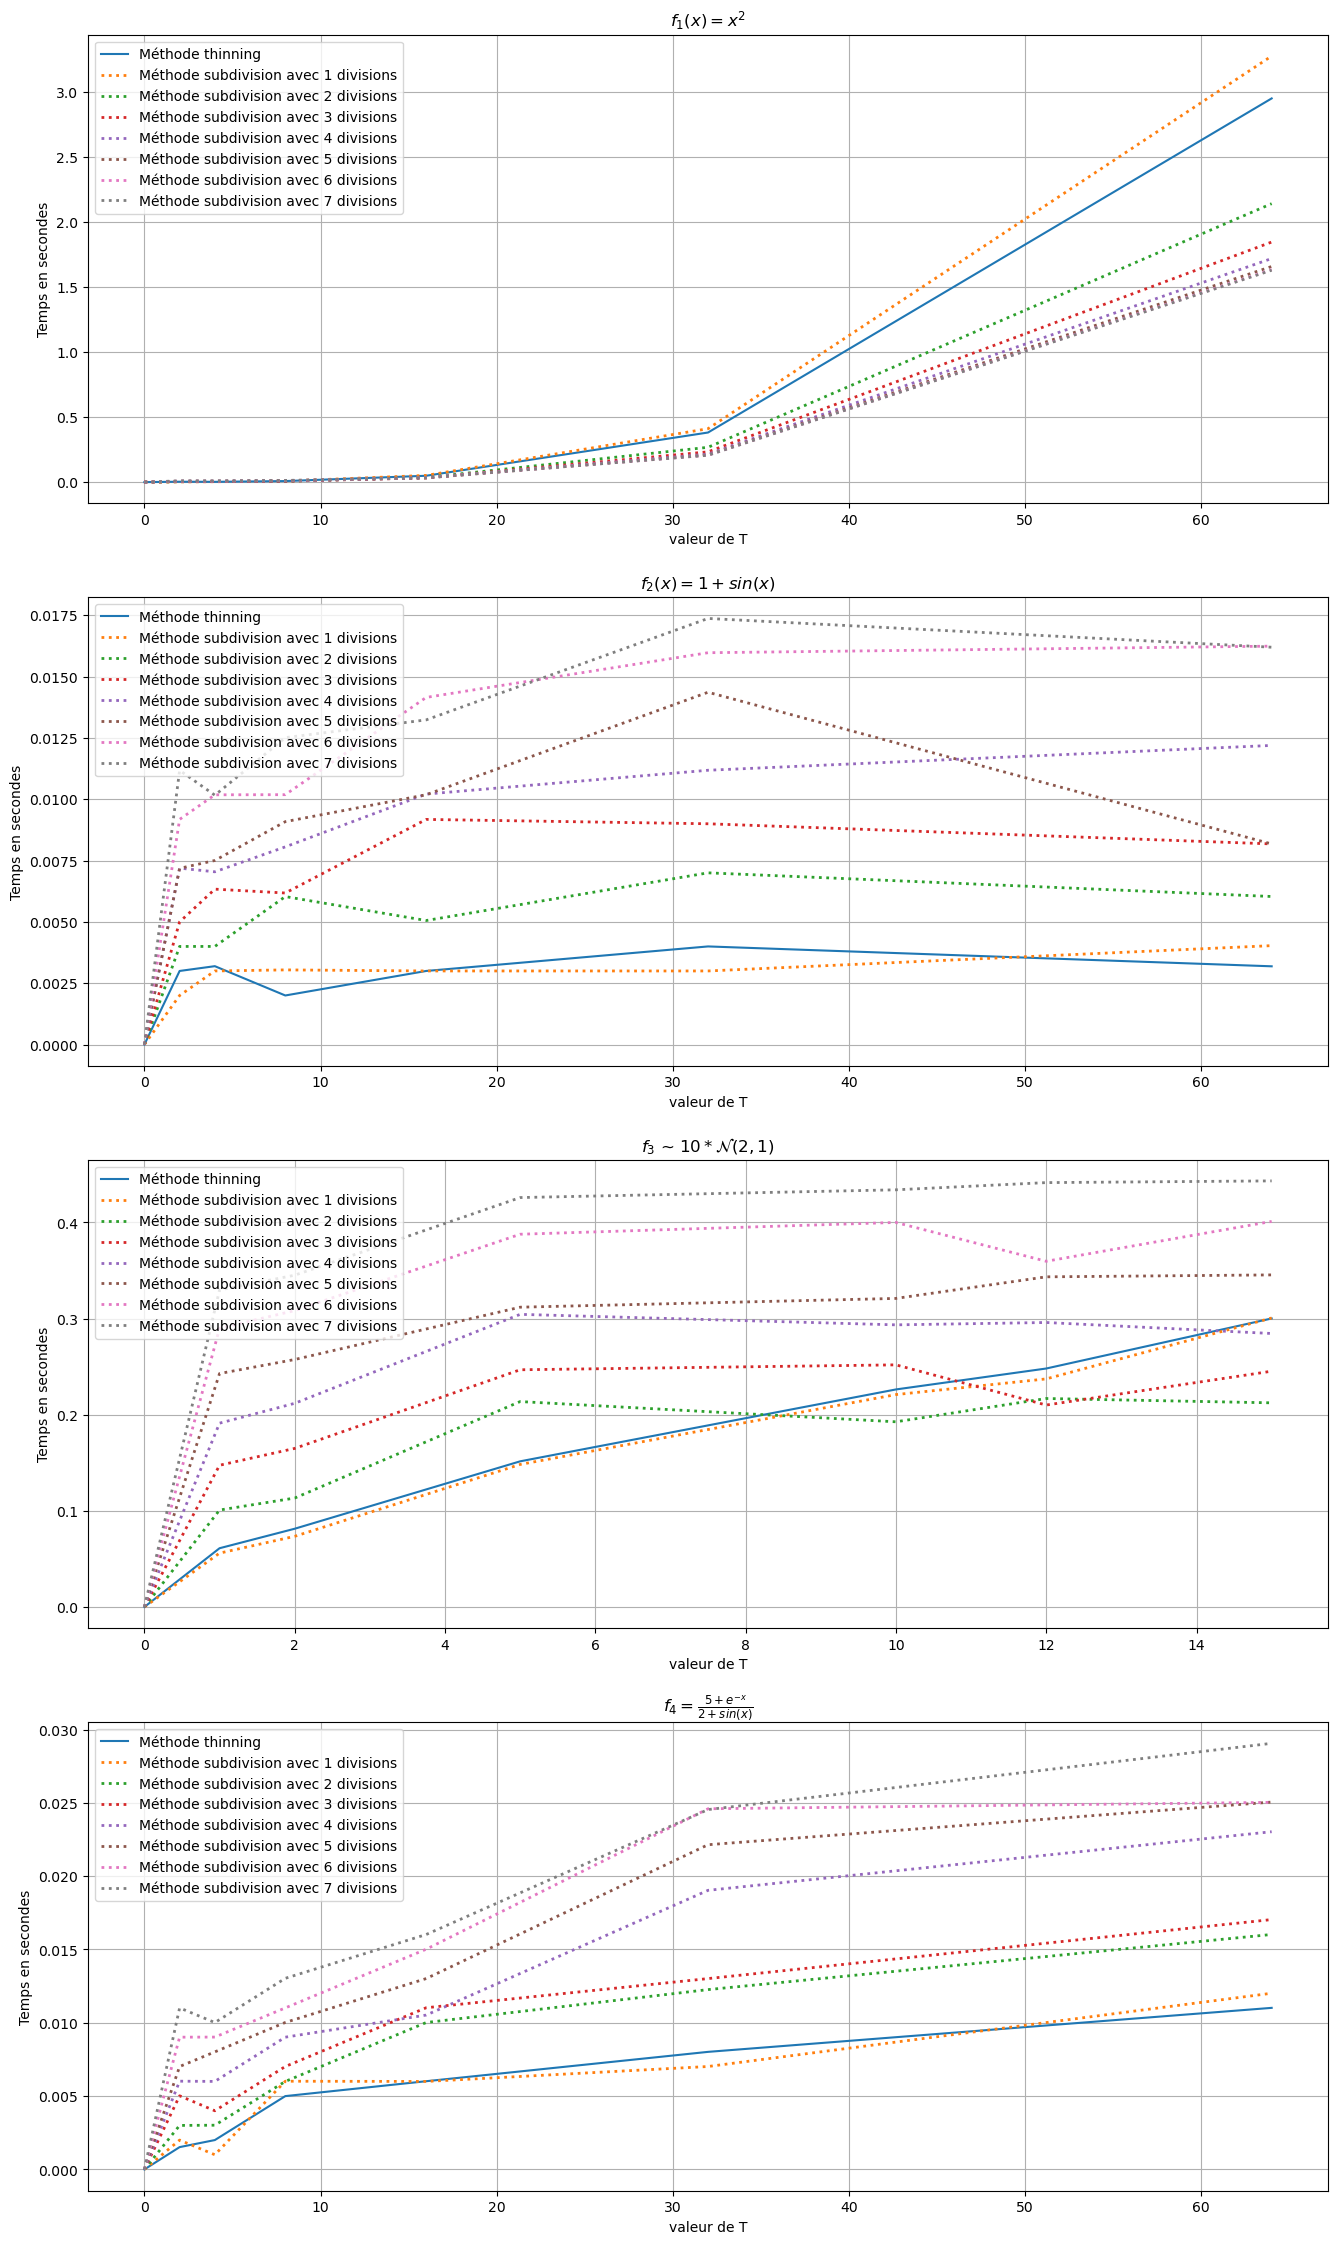

In [25]:
Ts = np.array([[0,2,4,8,16,32,64],[0,2,4,8,16,32,64],[0,1,2,5,10,12,15],[0,2,4,8,16,32,64]])
fs = [f1,f2,f3,f4]
fig = plt.figure(figsize=(16,28))

methodes = [Poisson_nonHomog√®ne_thinning, Poisson_nonHomog√®ne_subdivision]

nom = ['Thinning','Sub-Division']
for i,f in enumerate(fs) : 
    ax = fig.add_subplot(4,1,i+1)
    temp = [0]
    for T in Ts[i,1:]:
        start = time.time()
        sol = [Poisson_nonHomog√®ne_thinning(f,T) for _ in range(10)]
        end = time.time()
        temp.append(end-start)
    ax.plot(Ts[i],temp,label='M√©thode thinning')
    
    for j in range(1,8):
        temp = [0]
        for T in Ts[i,1:]:
            start = time.time()
            sol = [Poisson_nonHomog√®ne_subdivision(f,T,j) for _ in range(10)]
            end = time.time()
            temp.append(end-start)
        ax.plot(Ts[i],temp,label=f'M√©thode subdivision avec {j} divisions',linestyle='dotted',linewidth=2)
    
    
    ax.legend(loc="upper left")
    ax.grid()
    ax.set_title(nom_fonction[i])
    ax.set_xlabel('valeur de T')
    ax.set_ylabel('Temps en secondes')
plt.show()

Comme pr√©vu, augmenter le nombre de sub-divisions n'entraine pas une hausse des performances, mais plut√¥t le contraire √† cause du temps de calcul de recherche du sup. 

Dans le cas de $f_1=x^{2}$, on remarque cependant une augmentation des performances corr√©l√© au nombre de sub-divisions. De m√™me pour $f_{3}$ ~ $\mathcal{N}(2, 1)$, plus on s'√©loigne de la moyenne en t=2, plus les performances de l'algorithme de sub-division rattrapent la performance de la m√©thode de thinning.  Cette m√©thode semble donc pertinente dans certains cas limite.

On pourrait donc r√©√©crire la m√©thode de subdivision, en incluant une nouvelle partie qui calculerait automatiquement les intervalles de divisions optimaux (le cas nb_intervalles = 1 correspond √† la m√©thode de thinning simple). Reste √† trouver math√©matiquement cette valeur..
<br> <br>

Il existe bien s√ªr des algorithmes plus puissants pour simuler des processsus de poisson non homog√®nes, comme celui pr√©sent√© dans cet article de recherche:

https://yunanliu.wordpress.ncsu.edu/files/2019/11/CIATApublished.pdf